# Asking and Answering Questions on Stack Overflow
Stack Overflow has an official [How do I ask a good question?](https://stackoverflow.com/help/how-to-ask) guide.

Why do we care about the quality of the questions asked? Where does that put the pedagogical "There is no such thing as a bad question?"

Although there is an educational aspect to Stack Overflow, at the end of the day, it is a question and answer forum for developers to get and give help. If you are asking for help, you want to maximize your chances of getting it. In this context, we could rephrase "good" questions to be questions likely to be answered.

Stack Overflow has the feature that

> Sometimes users encounter the following message when posting a question: 
>> 'This post does not meet our quality standards.'

>If you see this message, then your question was automatically blocked by the server. All new questions are subjected to a "minimum quality" filter that checks for some basic indicators of a good, complete question. Check to make sure that your question has the following:
A clear title.
A reasonable explanation of what your question is. Add as much detail as you can.
Any background research you've tried but wasn't enough to solve your problem.
Correct use of English spelling and grammar to the best of your ability.

However, everything they list above is quite subjective. Let's explore if any immediately accessible features correlate with the question getting answered.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (11.7, 11.3)
plt.rcParams.update({'font.size': 20})
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.3)})
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

We will use a pre-processed data set on Stack Overflow Q&A for Python questions, found here: https://www.kaggle.com/stackoverflow/pythonquestions

In [2]:
Questions = pd.read_csv('LemmatizedQuestions.csv', encoding="ISO-8859-1")
Answers = pd.read_csv('LemmatizedAnswers.csv', encoding="ISO-8859-1")
Tags = pd.read_csv('pythonquestions/Tags.csv', encoding="ISO-8859-1")
Tags.columns = ['TID', 'Tag']

In [3]:
print(Questions.shape)
Questions.head(1)

(607282, 8)


,QID,QuestionUserId,QuestionCreateDate,QuestionScore,QuestionTitle,QuestionBody,QuestionTitleAndBody,QuestionTitleAndBodyLemmatized
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,How can I find the full path to a font from it...,"['how', 'can', 'i', 'find', 'the', 'full', 'pa..."


In [4]:
print(Answers.shape)
Answers.head(1)

(987122, 7)


,AID,AnswerUserId,AnswerCreateDate,ParentId,AnswerScore,AnswerBody,AnswerBodyLemmatized
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,"['open', 'up', 'a', 'terminal', 'applicationsg..."


In [5]:
print(Tags.shape)
Tags.head(3)

(1885078, 2)


,TID,Tag
0,469,python
1,469,osx
2,469,fonts


In [6]:
print(Questions.isnull().sum())
print(Answers.isnull().sum())
print(Tags.isnull().sum())

QID                                  0
QuestionUserId                    6212
QuestionCreateDate                   0
QuestionScore                        0
QuestionTitle                        0
QuestionBody                         0
QuestionTitleAndBody                 0
QuestionTitleAndBodyLemmatized       0
dtype: int64
AID                        0
AnswerUserId            5367
AnswerCreateDate           0
ParentId                   0
AnswerScore                0
AnswerBody                 0
AnswerBodyLemmatized       0
dtype: int64
TID      0
Tag    443
dtype: int64


Looks like this data is pretty clean. The only nulls are for users (probably users that have deleted their accounts since posting), and tags (since these are optional).

### Just curious: How many users are engaged on Q, A, & Q&A?

In [7]:
User_id_inQ = Questions['QuestionUserId'].unique()
User_id_inA = Answers['AnswerUserId'].unique()
User_id_inBoth=set(User_id_inQ).intersection(User_id_inA)

In [8]:
print(str(len(User_id_inQ)) + ' users posting questions')
print(str(len(User_id_inA)) + ' users posting answers')
print(str(len(User_id_inBoth)) + ' users posting both')

213928 users posting questions
149177 users posting answers
63779 users posting both


## So, what makes a good question?
Specifically "to improve your chances of getting an answer", Stack Overflow suggests
- Search and research before posting
- Have an informative title
- Include any error messages, key APIs, or unusual circumstances
- Introduce the problem before posting any code
- "Not all questions benefit from including code. But if your problem is with code you've written, you should include some."
- Include all relevant tags
- Proofread

Let's examine whether or not including error messages (and the closely related traceback), code, and tags truly improve a question's chances of getting an answer. Let's also take a look at the question length. We will first need to create the relevant features.

### Questions containing Python-formatted errors

In [9]:
Questions['HasError'] = Questions['QuestionBody'].str.contains("[A-Z][a-z]+Error:\s")

In [10]:
print(str(Questions['HasError'].sum() / Questions['HasError'].count()) + " of questions have a full Python-formatted error message")

0.14075997641952173 of questions have a full Python-formatted error message


### Questions containing Python-formatted tracebacks

In [11]:
Questions['HasTraceback'] = Questions['QuestionBody'].str.contains("Traceback \(most recent call last\):")

In [12]:
print(str(Questions['HasTraceback'].sum() / Questions['HasTraceback'].count()) + " of questions have a full Python-formatted traceback")

0.06771977433877506 of questions have a full Python-formatted traceback


### Questions containing code

In [13]:
Questions['HasMultiLineCode'] = Questions['QuestionBody'].str.contains("<code>.*\n.*</code>")

In [14]:
print(str(Questions['HasMultiLineCode'].sum() / Questions['HasMultiLineCode'].count()) + " of questions have multi line code")

0.23783514084066382 of questions have multi line code


### Overall average number of answers per question and answer rate per question

In [15]:
QA = Questions.merge(Answers, left_on='QID', right_on='ParentId')

In [16]:
AnswersPerQuestion = QA.groupby('QID').count().iloc[:,[0]].reset_index()
AnswersPerQuestion.columns = ['QID', 'NumAnswers']
Questions = Questions.merge(AnswersPerQuestion, how='left', on='QID')
Questions[['NumAnswers']] = Questions[['NumAnswers']].fillna(0)

In [17]:
def avgNumAnswers(df):
    return df['NumAnswers'].sum() / df.shape[0]
def avgAnswerRate(df):
    return (df.shape[0] - df.groupby('NumAnswers').count().iloc[0,0]) / df.shape[0]

In [18]:
print('total average answers ' + str(avgNumAnswers(Questions)))
print('total answer rate ' + str(avgAnswerRate(Questions)))

total average answers 1.6034527616494478
total answer rate 0.8780945261015476


### Question 1: Does including errors increase your expected number of answers or your likelihood of receiving an answer?

In [19]:
QuestionsHasError = Questions[Questions['HasError']]

print('error average answers ' + str(avgNumAnswers(QuestionsHasError)))
print('error answer rate ' + str(avgAnswerRate(QuestionsHasError)))

error average answers 1.4409049964319556
error answer rate 0.8675027199026685


### Question 2: What about tracebacks?

In [20]:
QuestionsHasTraceback = Questions[Questions['HasTraceback']]

print('traceback average answers ' + str(avgNumAnswers(QuestionsHasTraceback)))
print('traceback answer rate ' + str(avgAnswerRate(QuestionsHasTraceback)))

traceback average answers 1.3890091185410334
traceback answer rate 0.8483161094224924


### Question 3: What about both errors and tracebacks?

In [21]:
QuestionsHasErrorAndTraceback = Questions[(Questions['HasError'] & Questions['HasTraceback'])]

print('error traceback average answers ' + str(avgNumAnswers(QuestionsHasErrorAndTraceback)))
print('error traceback answer rate ' + str(avgAnswerRate(QuestionsHasErrorAndTraceback)))

error traceback average answers 1.4137732533478762
error traceback answer rate 0.858207598618433


### Question 4: Do questions with code have more or less answers or likelihood of receiving any answer?

In [22]:
QuestionsHasMultiLineCode = Questions[Questions['HasMultiLineCode']]

print('multiline code average answers ' + str(avgNumAnswers(QuestionsHasMultiLineCode)))
print('multiline code answer rate ' + str(avgAnswerRate(QuestionsHasMultiLineCode)))

multiline code average answers 1.6783560543643072
multiline code answer rate 0.8934523273767075


Yay! Finally a feature that corresponds with higher average number of answers and answer rate!

### Overall average number of tags per question

In [23]:
Questions.head(2)

,QID,QuestionUserId,QuestionCreateDate,QuestionScore,QuestionTitle,QuestionBody,QuestionTitleAndBody,QuestionTitleAndBodyLemmatized,HasError,HasTraceback,HasMultiLineCode,NumAnswers
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,How can I find the full path to a font from it...,"['how', 'can', 'i', 'find', 'the', 'full', 'pa...",False,False,False,4.0
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,Get a preview JPEG of a PDF on Windows? <p>I h...,"['get', 'a', 'preview', 'jpeg', 'of', 'a', 'pd...",False,False,False,3.0


In [24]:
QT = Questions.merge(Tags.dropna(axis=0, how='any'), left_on='QID', right_on='TID')

In [25]:
TagsPerQuestion = QT.groupby('QID').count().iloc[:,[0]].reset_index()
TagsPerQuestion.columns = ['QID', 'NumTags']
Questions = Questions.merge(TagsPerQuestion, how='left', on='QID')
Questions[['NumTags']] = Questions[['NumTags']].fillna(0)

In [26]:
total_average_tags = Questions['NumTags'].sum() / Questions.shape[0]
print('total average tags ' + str(total_average_tags))

total average tags 3.073772975322832


/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


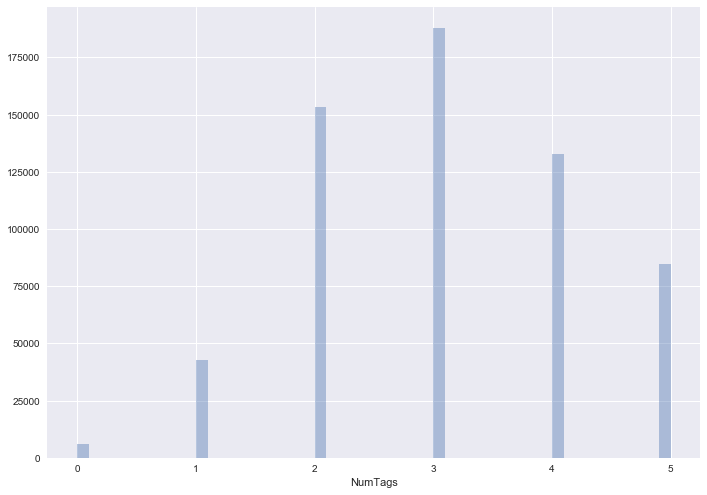

In [41]:
sns.distplot(Questions.NumTags , kde=False)

### Question 5: Do number of tags correspond to number of answers?

In [28]:
Questions.columns

Index(['QID', 'QuestionUserId', 'QuestionCreateDate', 'QuestionScore',
       'QuestionTitle', 'QuestionBody', 'QuestionTitleAndBody',
       'QuestionTitleAndBodyLemmatized', 'HasError', 'HasTraceback',
       'HasMultiLineCode', 'NumAnswers', 'NumTags'],
      dtype='object')

In [29]:
Questions.groupby('NumTags').sum()[['NumAnswers']] / Questions.groupby('NumTags').count()[['NumAnswers']]

,NumAnswers
NumTags,
0,0.000000
1,2.176044
2,1.710365
3,1.579643
4,1.508321
5,1.441169


This is also rather counterintuitive. Those with fewer tags had more answers (compared to the overall average of 1.6 answers). Stack Overflow uses tags to show questions to users on the STO homepage. Perhaps people don't go on the homepage much?

In [31]:
valuecounts = Tags['Tag'].value_counts()

In [61]:
top50tags = pd.DataFrame(valuecounts).index[:50]

In [66]:
'django' in top50tags

True

In [54]:
(valuecounts / Questions.shape[0] * 100).head(50)

python               100.000165
django                10.344123
python-2.7             5.700152
pandas                 4.421998
python-3.x             4.415412
numpy                  4.256342
list                   3.120626
matplotlib             2.720482
regex                  2.313093
dictionary             2.208694
tkinter                1.772817
string                 1.748117
flask                  1.727039
google-app-engine      1.693777
csv                    1.535201
arrays                 1.510007
json                   1.321133
mysql                  1.239786
linux                  1.172602
html                   1.172108
scipy                  1.137528
multithreading         1.120402
sqlalchemy             1.096855
windows                1.031975
beautifulsoup          0.996901
django-models          0.954581
javascript             0.953099
selenium               0.931034
xml                    0.878011
pyqt                   0.859074
class                  0.837008
osx     

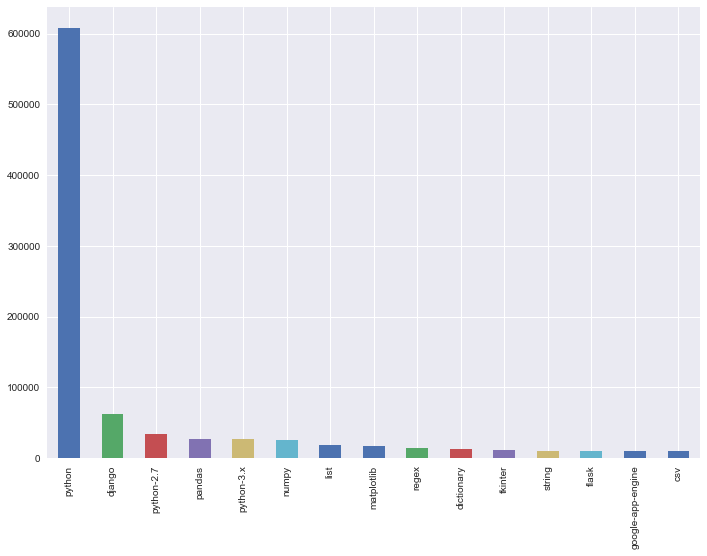

In [46]:
valuecounts[:15].plot(kind='bar')

Since all questions have the 'python' tag (this is the Python dataset), perhaps tags other than 'python' indicate specialization and therefore a smaller community.

Finally, let's take a look at how the length of the question affects the number of answers.

### Question length

In [34]:
Questions['QuestionLength'] = Questions['QuestionTitleAndBodyLemmatized'].apply(len)

In [35]:
print('The average Question has ' + str(Questions['QuestionLength'].mean()) + ' words.')

The average Question has 1545.3440642074029 words.


Let's take a look at the distribution.

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


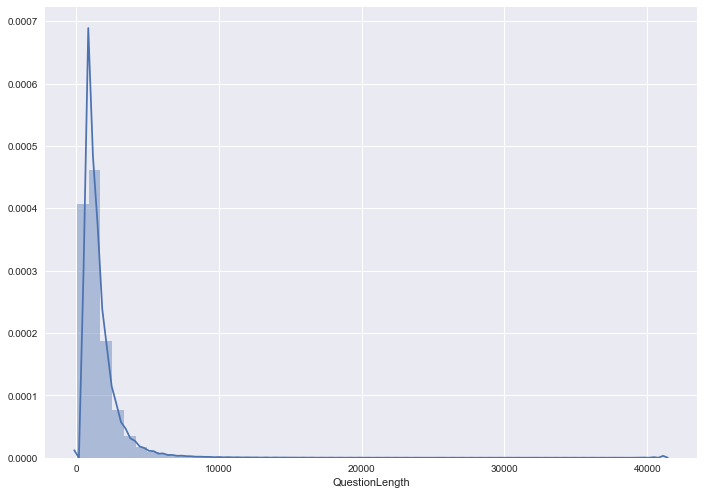

In [47]:
sns.distplot(Questions['QuestionLength'])

Looks like the number of words in questions are heavily skewed to the right. Let's zoom in on the head.

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[(0, 3000)]

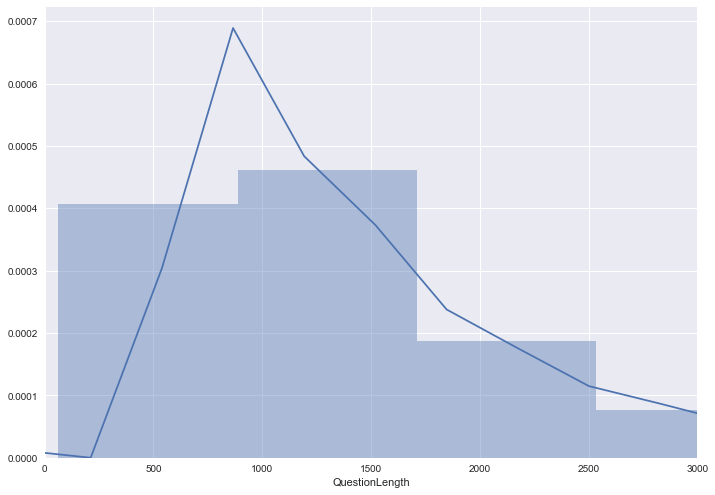

In [48]:
g = sns.distplot(Questions['QuestionLength'])
g.set(xlim=(0, 3000))

Looks like most questions have between 60 and 1750 words.

Now, for the ultimate test: is it true that "the most valuable of all talents is that of never using two words when one will do" ?

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


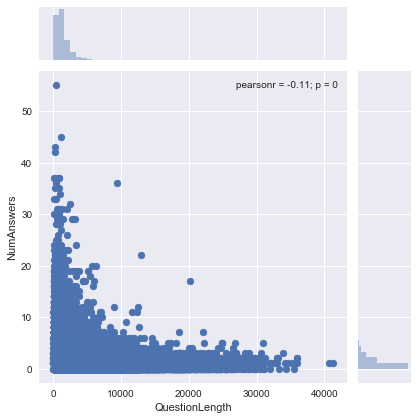

In [49]:
sns.jointplot(x="QuestionLength", y="NumAnswers", data=Questions)

This is a really dense plot, but we can see that the Pearson's correlation coefficient is negative. Let's make a regression plot with a low alpha value.

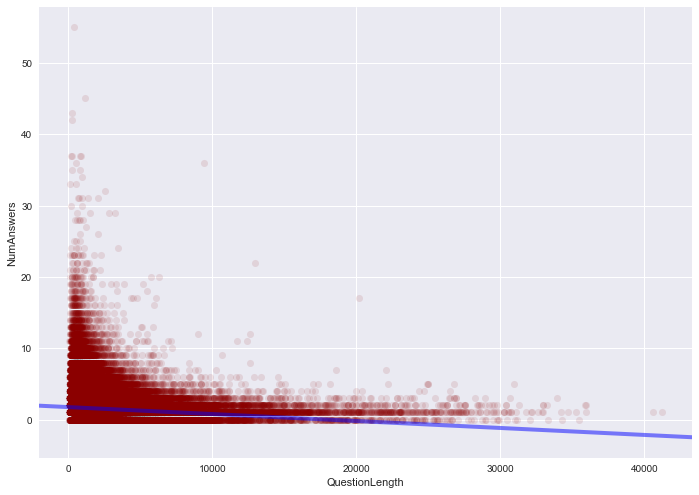

In [50]:
sns.regplot(x="QuestionLength", y="NumAnswers", data=Questions, 
    ci = None,
    scatter_kws={"color":"darkred","alpha":0.1,"s":50},
    line_kws={"color":"b","alpha":0.5,"lw":4})

From this plot, we can see that questions that get many answers tend to have fewer words. Across all question lengths, there are many questions with vew answers--this contributed to the low slope and low intercept of the regression line.

## Conclusion

Overall, it seems like many easily capturable "common sense" practices of asking good questions didn't translate to more answers or higher likelihoods of getting an answer. It'd be interesting to know how Stack Overflow's server automatically filters out questions that don't meet minimum standards.

However, we did find that including at least two lines of code does help improve both number of answers and likelihood of getting an answer, and keeping your questions short also tends to lead to more answers. Hope this was interesting and got you thinking about what makes a "good" question!

In [53]:
Questions.columns

Index(['QID', 'QuestionUserId', 'QuestionCreateDate', 'QuestionScore',
       'QuestionTitle', 'QuestionBody', 'QuestionTitleAndBody',
       'QuestionTitleAndBodyLemmatized', 'HasError', 'HasTraceback',
       'HasMultiLineCode', 'NumAnswers', 'NumTags', 'QuestionLength'],
      dtype='object')

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


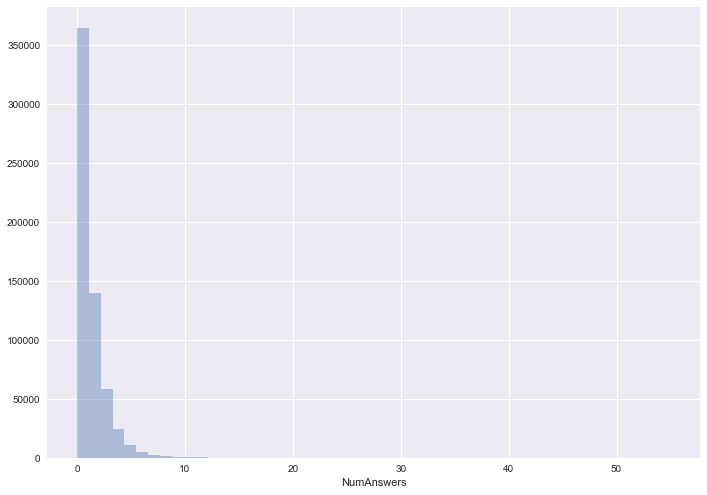

In [58]:
sns.distplot(Questions['NumAnswers'], kde=False)